In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

import sys
sys.path.append('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/')

from enum import Enum

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp
from scipy.stats import beta, truncnorm


# Local imports from model.py, data.py
from model import CovidModel, LogPoissonProb, get_logging_callbacks, Comp, Vax
from data import read_data, create_warmup
#from plots import make_all_plots

import scipy

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

2022-01-06 20:02:47.753479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-06 20:02:47.753517: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
transition_window =10

warmup_start = '20210421'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = '../data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

# Learning rate
model_learning_rate = 1e-2
warmup_learning_rate = 20
learning_rate = 1

In [3]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)

In [4]:
# get warmup arrays, splitting on vaccination status
warmup_asymp, warmup_mild, warmup_extreme = create_warmup(df, 
                                                          warmup_start, 
                                                          warmup_end,
                                                          0,0,0)

# re-combine
warmup_asymp = warmup_asymp[Vax.no.value] + warmup_asymp[Vax.yes.value]
warmup_mild = warmup_mild[Vax.no.value] + warmup_asymp[Vax.yes.value]

In [5]:
synth_T_serial = 5.8
synth_rho_M = 0.76
synth_lambda_M = 4.7
synth_nu_M = 3.1

In [6]:
warmup_A_params = {}
warmup_A_params[Vax.total.value] = {}
warmup_A_params[Vax.total.value]['prior'] = []
warmup_A_params[Vax.total.value]['posterior_init'] = []

warmup_M_params = {}
warmup_M_params[Vax.total.value] = {}
warmup_M_params[Vax.total.value]['prior'] = []
warmup_M_params[Vax.total.value]['posterior_init'] = []

for day in range(transition_window):
    warmup_A_params[Vax.total.value]['prior'].append({'loc': warmup_asymp[day],
                                                'scale': warmup_asymp[day]/10})
    
    warmup_M_params[Vax.total.value]['prior'].append({'loc': warmup_mild[day],
                                                'scale': warmup_mild[day]/10})
    

In [7]:
x_train = tf.cast(df.loc[train_start:test_end,'Rt'].values, dtype=tf.float32)
y_test = tf.cast(df.loc[train_start:test_end,'general_ward'], dtype=tf.float32)

2022-01-06 20:02:49.676404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-06 20:02:49.676604: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-06 20:02:49.676642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-01-06 20:02:49.676672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-01-06 20:02:49.676701: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [8]:
A_vals = []
M_vals =[]
for day in range(transition_window):
    A_vals.append(warmup_A_params[-1]['prior'][day]['loc'])

for day in range(len(x_train)):
    yesterday_asymp = A_vals[-1]
    
    today_asymp = yesterday_asymp*x_train[day]**(1/synth_T_serial)
    A_vals.append(today_asymp)
    
    today_M = 0
    pi_M=[]
    for j in range(transition_window):
        
        
        lambda_M_fix = synth_lambda_M
        nu_M_fix = synth_nu_M
        poisson_dist = scipy.stats.poisson(lambda_M_fix)
        pi_M_j_ago = poisson_dist.logpmf(j+1)/nu_M_fix
        
        pi_M.append(pi_M_j_ago)
    
    pi_M = scipy.special.softmax(pi_M)
        
    for j in range(transition_window):
        j_ago_asymp = A_vals[day-j-1]
        today_M += j_ago_asymp*synth_rho_M*pi_M[j]
        
    M_vals.append(today_M)

In [9]:

T_serial = {}
T_serial[Vax.total.value] = {}
T_serial[Vax.total.value]['prior'] ={'loc':5.8, 'scale':1}


rho_M = {}
rho_M[Vax.total.value] = {}
rho_M[Vax.total.value]['prior'] = {'a': 31.8, 'b': 10.3}

lambda_M = {}
lambda_M[Vax.total.value] = {}
lambda_M[Vax.total.value]['prior'] = {'loc': 4.7, 'scale': 1}

nu_M = {}
nu_M[Vax.total.value] = {}
nu_M[Vax.total.value]['prior'] = {'loc': 3.1, 'scale': 1.2}

rho_G = {}
rho_G[Vax.total.value] = {}
rho_G[Vax.total.value]['prior'] = {'a': 31.8, 'b': 10.3}

lambda_G = {}
lambda_G[Vax.total.value] = {}
lambda_G[Vax.total.value]['prior'] = {'loc': 3.3, 'scale': 1.0}

nu_G = {}
nu_G[Vax.total.value] = {}
nu_G[Vax.total.value]['prior'] = {'loc': 9.0, 'scale': 0.2}




In [10]:
T_serial_scale = 1.0
rho_M_scale = 0.1
lambda_M_scale = 1.0
nu_M_scale = 1.2

rho_G_scale = 0.1
lambda_G_scale = 1.0
nu_G_scale = 0.2

warmup_scales = [0.1]*warmup_asymp

In [11]:
T_serial[Vax.total.value]['posterior_init'] = {'loc': tfp.math.softplus_inverse(4.0),
                                     'scale':tf.cast(tfp.math.softplus_inverse(T_serial_scale),dtype=tf.float32)}

rho_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(np.log(0.5/(1-0.5)),dtype=tf.float32),
                                      'scale':tf.cast(tfp.math.softplus_inverse(rho_M_scale),dtype=tf.float32)}

lambda_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(3.0),dtype=tf.float32),
                                         'scale':tf.cast(tfp.math.softplus_inverse(lambda_M_scale),dtype=tf.float32)}

nu_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(5.0),dtype=tf.float32),
                                     'scale':tf.cast(tfp.math.softplus_inverse(nu_M_scale),dtype=tf.float32)}

rho_G[Vax.total.value]['posterior_init'] = {'loc': tf.cast(np.log(0.1/(1-0.1)),dtype=tf.float32),
                                      'scale':tf.cast(tfp.math.softplus_inverse(rho_G_scale),dtype=tf.float32)}

lambda_G[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(3.3),dtype=tf.float32),
                                         'scale':tf.cast(tfp.math.softplus_inverse(lambda_G_scale),dtype=tf.float32)}

nu_G[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(9.0),dtype=tf.float32),
                                     'scale':tf.cast(tfp.math.softplus_inverse(nu_G_scale),dtype=tf.float32)}

for day in range(transition_window):
    # must be positive so reverse softplus the mean
    warmup_A_params[Vax.total.value]['posterior_init'].append({'loc': tf.cast(tfp.math.softplus_inverse(2000.0),dtype=tf.float32),
                                                         'scale': tf.cast(tfp.math.softplus_inverse(500.0),dtype=tf.float32)})#tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]/10),dtype=tf.float32)})

    warmup_M_params[Vax.total.value]['posterior_init'].append({'loc': tf.cast(tfp.math.softplus_inverse(1000.0),dtype=tf.float32),
                                                         'scale': tf.cast(tfp.math.softplus_inverse(100.0),dtype=tf.float32)})#tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]/10),dtype=tf.float32)})

model = CovidModel([Vax.total], [Comp.A, Comp.M, Comp.G],
                 transition_window,
                T_serial, rho_M, lambda_M, nu_M, rho_G, lambda_G, nu_G,
                 warmup_A_params, warmup_M_params, posterior_samples=1000, debug_disable_theta=False)

pre_training_preds=tf.reduce_mean(model.call(x_train), axis=-1)

2022-01-06 20:02:54.916289: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [12]:
model.variables

2022-01-06 20:02:54.977673: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


[<tf.Variable 'T_serial_A_loc_-1:0' shape=() dtype=float32, numpy=3.9815147>,
 <tf.Variable 'T_serial_A_scale_-1:0' shape=() dtype=float32, numpy=0.54132485>,
 <tf.Variable 'rho_M_loc_-1:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'rho_M_scale_-1:0' shape=() dtype=float32, numpy=-2.2521684>,
 <tf.Variable 'lambda_M_loc_-1:0' shape=() dtype=float32, numpy=2.9489307>,
 <tf.Variable 'lambda_M_scale_-1:0' shape=() dtype=float32, numpy=0.54132485>,
 <tf.Variable 'nu_M_loc_-1:0' shape=() dtype=float32, numpy=4.9932394>,
 <tf.Variable 'nu_M_scale_-1:0' shape=() dtype=float32, numpy=0.8416177>,
 <tf.Variable 'rho_G_loc_-1:0' shape=() dtype=float32, numpy=-2.1972246>,
 <tf.Variable 'rho_G_scale_-1:0' shape=() dtype=float32, numpy=-2.2521684>,
 <tf.Variable 'lambda_G_loc_-1:0' shape=() dtype=float32, numpy=3.2624195>,
 <tf.Variable 'lambda_G_scale_-1:0' shape=() dtype=float32, numpy=0.54132485>,
 <tf.Variable 'nu_G_loc_-1:0' shape=() dtype=float32, numpy=8.999877>,
 <tf.Variable 'nu_G_s

In [13]:
model_variables = model.variables[:-4*transition_window]
assert all(['warmup' not in variable.name for variable in model_variables])
warmup_variables = model.variables[-4*transition_window:]
assert all(['warmup' in variable.name for variable in warmup_variables])

In [14]:
loss = LogPoissonProb() 
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1, #beta_1=0.1, beta_2=0.1
)

In [15]:
logging_callbacks = get_logging_callbacks('/mnt/c/Users/kheut/logs/covid/bayes_learn_all_estim_flex_warm_hosp')

2022-01-06 20:02:55.080078: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-06 20:02:55.080111: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-06 20:02:55.080138: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-01-06 20:02:55.080333: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2022-01-06 20:02:55.080389: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so'; dlerror: libcupti.so: cannot open shared object file: No such file or directory
2022-01-06 20:02:55.080405: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be 

In [16]:
model.compile(loss=loss, optimizer=optimizer, run_eagerly=True)
model.fit(x=np.asarray([x_train]), y=np.asarray([y_test]),
         epochs=500, batch_size=0,
        callbacks=logging_callbacks)

Epoch 1/500
1/1 [==============================] - 7s 7s/step - loss: 3348.8704
Epoch 2/500


2022-01-06 20:03:02.152701: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-06 20:03:02.152733: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-06 20:03:02.152965: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


1/1 [==============================] - ETA: 0s - loss: 1577.7461

2022-01-06 20:03:10.103964: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-06 20:03:10.135036: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2022-01-06 20:03:10.738780: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-01-06 20:03:11.942533: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-06 20:03:14.134136: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /mnt/c/Users/kheut/logs/covid/bayes_learn_all_estim_flex_warm_hosp/train/plugins/profile/2022_01_06_20_03_11

2022-01-06 20:03:15.163233: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /mnt/c/Users/kheut/logs/covid/bayes_learn_all_estim_flex_

1/1 [==============================] - 14s 14s/step - loss: 1577.7461


2022-01-06 20:03:15.780889: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /mnt/c/Users/kheut/logs/covid/bayes_learn_all_estim_flex_warm_hosp/train/plugins/profile/2022_01_06_20_03_11

2022-01-06 20:03:15.782821: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to /mnt/c/Users/kheut/logs/covid/bayes_learn_all_estim_flex_warm_hosp/train/plugins/profile/2022_01_06_20_03_11/MrChipsNVME.memory_profile.json.gz
2022-01-06 20:03:15.818071: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: /mnt/c/Users/kheut/logs/covid/bayes_learn_all_estim_flex_warm_hosp/train/plugins/profile/2022_01_06_20_03_11
Dumped tool data for xplane.pb to /mnt/c/Users/kheut/logs/covid/bayes_learn_all_estim_flex_warm_hosp/train/plugins/profile/2022_01_06_20_03_11/MrChipsNVME.xplane.pb
Dumped tool data for overview_page.pb to /mnt/c/Users/kheut/logs/covid/bayes_learn_all_estim_flex_warm_hosp/train

Epoch 3/500
1/1 [==============================] - 6s 6s/step - loss: 2718.0986
Epoch 4/500
1/1 [==============================] - 6s 6s/step - loss: 3195.1118
Epoch 5/500
1/1 [==============================] - 7s 7s/step - loss: 3351.9050
Epoch 6/500
1/1 [==============================] - 6s 6s/step - loss: 3330.8645
Epoch 7/500
1/1 [==============================] - 6s 6s/step - loss: 3135.4106
Epoch 8/500
1/1 [==============================] - 6s 6s/step - loss: 2819.9795
Epoch 9/500
1/1 [==============================] - 6s 6s/step - loss: 2308.0642
Epoch 10/500
1/1 [==============================] - 6s 6s/step - loss: 1671.4543
Epoch 11/500
1/1 [==============================] - 6s 6s/step - loss: 1148.6804
Epoch 12/500
1/1 [==============================] - 7s 7s/step - loss: 1344.5668
Epoch 13/500
1/1 [==============================] - 6s 6s/step - loss: 2048.6035
Epoch 14/500
1/1 [==============================] - 6s 6s/step - loss: 1870.1060
Epoch 15/500
1/1 [=================

1/1 [==============================] - 6s 6s/step - loss: 796.9288
Epoch 106/500
1/1 [==============================] - 6s 6s/step - loss: 793.8070
Epoch 107/500
1/1 [==============================] - 6s 6s/step - loss: 792.9310
Epoch 108/500
1/1 [==============================] - 6s 6s/step - loss: 797.5060
Epoch 109/500
1/1 [==============================] - 6s 6s/step - loss: 794.1595
Epoch 110/500
1/1 [==============================] - 6s 6s/step - loss: 792.5648
Epoch 111/500
1/1 [==============================] - 6s 6s/step - loss: 790.6147
Epoch 112/500
1/1 [==============================] - 6s 6s/step - loss: 789.4545
Epoch 113/500
1/1 [==============================] - 6s 6s/step - loss: 796.0435
Epoch 114/500
1/1 [==============================] - 6s 6s/step - loss: 792.7366
Epoch 115/500
1/1 [==============================] - 6s 6s/step - loss: 791.0441
Epoch 116/500
1/1 [==============================] - 6s 6s/step - loss: 786.0535
Epoch 117/500
1/1 [=======================

1/1 [==============================] - 6s 6s/step - loss: 744.2672
Epoch 207/500
1/1 [==============================] - 6s 6s/step - loss: 747.4236
Epoch 208/500
1/1 [==============================] - 6s 6s/step - loss: 749.8662
Epoch 209/500
1/1 [==============================] - 6s 6s/step - loss: 744.4704
Epoch 210/500
1/1 [==============================] - 6s 6s/step - loss: 742.6169
Epoch 211/500
1/1 [==============================] - 6s 6s/step - loss: 749.4337
Epoch 212/500
1/1 [==============================] - 6s 6s/step - loss: 741.8408
Epoch 213/500
1/1 [==============================] - 6s 6s/step - loss: 743.5417
Epoch 214/500
1/1 [==============================] - 6s 6s/step - loss: 742.3994
Epoch 215/500
1/1 [==============================] - 6s 6s/step - loss: 744.8571
Epoch 216/500
1/1 [==============================] - 6s 6s/step - loss: 741.4506
Epoch 217/500
1/1 [==============================] - 6s 6s/step - loss: 739.7100
Epoch 218/500
1/1 [=======================

1/1 [==============================] - 6s 6s/step - loss: 707.3764
Epoch 308/500
1/1 [==============================] - 6s 6s/step - loss: 703.3818
Epoch 309/500
1/1 [==============================] - 6s 6s/step - loss: 703.7422
Epoch 310/500
1/1 [==============================] - 6s 6s/step - loss: 706.3460
Epoch 311/500
1/1 [==============================] - 6s 6s/step - loss: 706.8279
Epoch 312/500
1/1 [==============================] - 6s 6s/step - loss: 706.0713
Epoch 313/500
1/1 [==============================] - 6s 6s/step - loss: 704.2359
Epoch 314/500
1/1 [==============================] - 6s 6s/step - loss: 703.9357
Epoch 315/500
1/1 [==============================] - 6s 6s/step - loss: 702.9852
Epoch 316/500
1/1 [==============================] - 6s 6s/step - loss: 706.7686
Epoch 317/500
1/1 [==============================] - 6s 6s/step - loss: 702.6719
Epoch 318/500
1/1 [==============================] - 6s 6s/step - loss: 705.3606
Epoch 319/500
1/1 [=======================

1/1 [==============================] - 6s 6s/step - loss: 677.7157
Epoch 409/500
1/1 [==============================] - 6s 6s/step - loss: 678.4384
Epoch 410/500
1/1 [==============================] - 6s 6s/step - loss: 677.7540
Epoch 411/500
1/1 [==============================] - 6s 6s/step - loss: 677.0594
Epoch 412/500
1/1 [==============================] - 6s 6s/step - loss: 676.8602
Epoch 413/500
1/1 [==============================] - 6s 6s/step - loss: 675.9308
Epoch 414/500
1/1 [==============================] - 6s 6s/step - loss: 678.0338
Epoch 415/500
1/1 [==============================] - 6s 6s/step - loss: 676.4786
Epoch 416/500
1/1 [==============================] - 6s 6s/step - loss: 674.6417
Epoch 417/500
1/1 [==============================] - 6s 6s/step - loss: 675.0526
Epoch 418/500
1/1 [==============================] - 6s 6s/step - loss: 674.2472
Epoch 419/500
1/1 [==============================] - 6s 6s/step - loss: 674.4622
Epoch 420/500
1/1 [=======================

SystemError: <built-in method __array__ of numpy.ndarray object at 0x7fa2505fed50> returned a result with an error set

Text(0.5, 1.0, 'Mild Compartment')

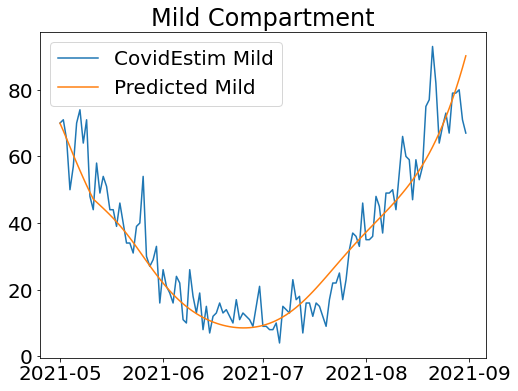

In [17]:
plt.figure(figsize=(8, 6))
preds=tf.reduce_mean(model.call(x_train), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, y_test, label='CovidEstim Mild')
plt.plot(df.loc[train_start:test_end].index.values, preds, label='Predicted Mild')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Mild Compartment')

Text(0.5, 1.0, 'Mild Compartment')

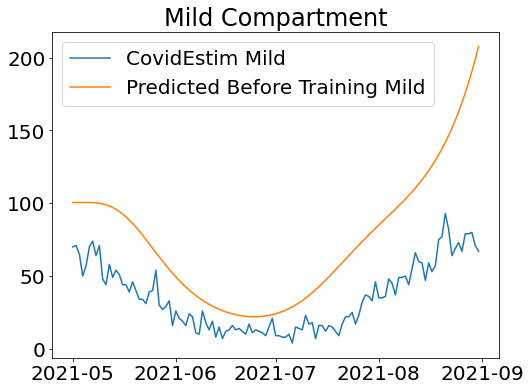

In [18]:
plt.figure(figsize=(8, 6))
preds=tf.reduce_mean(model.call(x_train), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, y_test, label='CovidEstim Mild')
plt.plot(df.loc[train_start:test_end].index.values, pre_training_preds, label='Predicted Before Training Mild')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Mild Compartment')

In [ ]:
import tfa.optimizers

In [ ]:
0.8*2000

In [ ]:
warmup_asymp

In [ ]:
warmup_mild

In [ ]:
y_test

In [ ]:
df.loc[warmup_start:'20210510','mild']

In [ ]:
warmup_start

In [ ]:
warmup_asymp

In [ ]:
import copy

In [ ]:
copy_model = copy.deepcopy(model)
copy_model.unconstrained_warmup_A_params[-1][2]['loc'] = tf.Variable(2500.0, dtype=tf.float32)
copy_model.unconstrained_warmup_A_params[-1][1]['loc'] = tf.Variable(2500.0, dtype=tf.float32)
copy_model.unconstrained_warmup_A_params[-1][0]['loc'] = tf.Variable(2500.0, dtype=tf.float32)
copy_model.unconstrained_nu_M[-1]['loc'] = tf.Variable(3.0, dtype=tf.float32)

In [ ]:
plt.figure(figsize=(8, 6))
copy_preds=tf.reduce_mean(copy_model.call(x_train), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, y_test, label='CovidEstim Mild')
plt.plot(df.loc[train_start:test_end].index.values, copy_preds, label='Predicted Mild')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Mild Compartment')

In [ ]:
loss(y_test, copy_model.call(x_train))

In [ ]:
copy_model.unconstrained_nu_M

In [ ]:
copy_model.unconstrained_rho_M[-1]['loc']

In [ ]:
tf.math.sigmoid(1.2)

In [ ]:
warmup_A_params[-1]

In [ ]:
warmup_asymp

In [ ]:
warmup_mild

In [ ]:
1800/2500

In [ ]:
plt.figure(figsize=(8, 6))
copy_preds=tf.reduce_mean(copy_model.call(x_train), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, df.loc[train_start:test_end, 'mild']/df.loc[train_start:test_end, 'asymp'], label='Asymp/Mild')
#plt.plot(df.loc[train_start:test_end].index.values, preds, label='Predicted Mild')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Empirical Rho_M')

In [ ]:
0.96**(1/5.2)

In [ ]:
warmup_asymp

In [ ]:
x_train

In [ ]:
model.T_serial_samples_constrained

In [ ]:
copy_model.call(x_train,return_all=True)

In [ ]:
warmup_asymp*x_train[2] ** (1/model.T_serial_samples_constrained)

In [ ]:
copy_model.warmup_A_samples[1]

In [ ]:
warmup_A